## Домашнее задание #1

### Выполнил:
> Залесинский Роман, МОВС23, @roman_zalesinskii

### Deadline
> Срок: 30 ноября 23:59

### Описание


**В файле:**

- id - id записи
- id_session - id экземпляра процесса
- stage - этап процесса
- time_end - время окончания этапа процесса

**Задача:** 
- написать пайплайн на Python для поиска неэффективностей в процессе
- Число неэффективностей в процессе по условию не известно.

За нахождение всех неэффективностей ставится 100% - 20 баллов. За подсвечивание неэффективностей, которых в реальности нет - снимаются баллы.

Прислать нужно код Python и таблицу со списком неэффективностей в формате: этап процесса / описание неэффективности


### Таблица неэффективностей

| Неэффективность                               | Количество |
|----------------------------------------------|------------|
| Количество процессов с зацикленностями "В себя"   | 133        |
| Количество процессов с зацикленностями "В начало" | 10         |


| Этап                     | Описание                                                                 |
|--------------------------|--------------------------------------------------------------------------|
| Выезд к клиенту          | Есть один огромный выброс, не знаю как это классифицировать - возможно разовый инцидент |
| Получение оборудования на складе | многократные инциденты                                                   |


## Code

In [1]:
#!pip install sberpm

In [2]:
# Работа с данными
import pandas as pd
import numpy as np

# Модуль для работы с SberPM
from sberpm import DataHolder
from sberpm.visual import GraphvizPainter
from sberpm.miners import SimpleMiner, CausalMiner, HeuMiner, AlphaMiner, AlphaPlusMiner, CorrelationMiner
from sberpm.metrics import ActivityMetric, TransitionMetric, IdMetric, TraceMetric, UserMetric

# Для визуализации
import matplotlib.pyplot as plt

# Модули для анализа данных
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from scipy.stats import kurtosis, shapiro
import scipy.stats as stats

### 1. EDA

In [3]:
df = pd.read_csv('data/Task1_l6s.csv', delimiter=';')
df.tail()

,id,id_session,stage,time_end
1698,1699,133,Согласование заявки бухгалером,14.03.2024 21:24
1699,1700,133,Получение оборудования на складе,15.03.2024 3:24
1700,1701,133,Выезд к клиенту,15.03.2024 4:24
1701,1702,133,Оборудование успешно установлено,15.03.2024 5:24
1702,1703,133,Формирование отчета о выезде,15.03.2024 7:00


In [4]:
df.describe()

,id,id_session
count,1703.000000,1703.000000
mean,852.000000,66.673517
std,491.758071,38.298862
min,1.000000,1.000000
25%,426.500000,34.000000
50%,852.000000,67.000000
75%,1277.500000,100.000000
max,1703.000000,133.000000


In [5]:
df.isnull().sum()

id            0
id_session    0
stage         0
time_end      0
dtype: int64

#### Добавляем колонки со временем начала этапа и его длительностью

In [6]:
# Конвертируем 'time_end' во времянной формат
df['time_end'] = pd.to_datetime(df['time_end'], format='%d.%m.%Y %H:%M')

# На всякий случай сортируем по времени оконачания процесса 'time_end'
df.sort_values(by=['id_session', 'time_end'], inplace=True)

# Добавляем время начала
df['time_start'] = df.groupby('id_session')['time_end'].shift(1)

# Заполняем первые инициирующие процессы вроде прихода заявки 
df['time_start'] = df['time_start'].fillna(df['time_end'])

# Добавляем длительность процесса
df['duration'] = (df['time_end'] - df['time_start']).dt.total_seconds() / 60

# Меняем местами time_start и time_end
df = df[['id', 'id_session', 'stage', 'time_start', 'time_end', 'duration']]

df.head(15)

,id,id_session,stage,time_start,time_end,duration
0,1,1,Поступление заявки на установку оборудования,2024-02-01 10:00:00,2024-02-01 10:00:00,0.0
1,2,1,Рассмотрение заявки менеджером,2024-02-01 10:00:00,2024-02-01 11:00:00,60.0
2,3,1,Рассмотрение заявки менеджером,2024-02-01 11:00:00,2024-02-01 12:00:00,60.0
3,4,1,Рассмотрение заявки менеджером,2024-02-01 12:00:00,2024-02-01 13:00:00,60.0
4,5,1,Рассмотрение заявки инженером,2024-02-01 13:00:00,2024-02-01 14:00:00,60.0
5,6,1,Согласование заявки инженером,2024-02-01 14:00:00,2024-02-01 15:00:00,60.0
6,7,1,Согласование заявки юристом,2024-02-01 15:00:00,2024-02-01 16:00:00,60.0
7,8,1,Согласование заявки бухгалером,2024-02-01 16:00:00,2024-02-01 17:00:00,60.0
8,9,1,Получение оборудования на складе,2024-02-01 17:00:00,2024-02-01 23:00:00,360.0
9,10,1,Выезд к клиенту,2024-02-01 23:00:00,2024-02-02 00:00:00,60.0


#### Создадим новый датафрейм, где будут мы сгруппируем процессы по их id, сгруппируем их, посчитаем длительность и посмотрим закончились они или нет.

In [7]:
for i in df['stage'].unique():
    print(i)

Поступление заявки на установку оборудования
Рассмотрение заявки менеджером
Рассмотрение заявки инженером
Согласование заявки инженером
Согласование заявки юристом
Согласование заявки бухгалером
Получение оборудования на складе
Выезд к клиенту
Оборудование успешно установлено
Формирование отчета о выезде
Назначение материалоответственного
Проверка перечня наминклатуры бухгалтером


In [8]:
# оптимальный порядок выполнения процесса(пост знание - получим когда построим граф дальше)
operations_dict = {
    "Поступление заявки на установку оборудования": "A",
    "Рассмотрение заявки менеджером": "B",
    "Рассмотрение заявки инженером": "C",
    "Согласование заявки инженером": "D",
    "Согласование заявки юристом": "E",
    "Согласование заявки бухгалером": "F",
    "Проверка перечня наминклатуры бухгалтером": "G",
    "Назначение материалоответственного": "H",
    "Получение оборудования на складе": "I",
    "Выезд к клиенту": "J",
    "Оборудование успешно установлено": "K",
    "Формирование отчета о выезде": "L"
}

In [9]:
df["stage_L"] = df["stage"].map(operations_dict)

assert 0 == len(df[df["stage_L"].isna()])

In [10]:
# Группировка по id_session и создание строки из последовательного соединения stage_L
df_processes = (
    df.groupby("id_session")["stage_L"]
    .apply(lambda x: "".join(x))
    .reset_index()
)

# Переименование колонки stage_L в process
df_processes.rename(columns={"stage_L": "process"}, inplace=True)

In [11]:
# Процесс выполнен если в конце мы сделали отчет
is_finished = df.groupby("id_session")["stage"].apply(
    lambda x: "Формирование отчета о выезде" in x.values
).astype(int)

# Добавляем колонку с длительностью процесса
duration_sum = df.groupby("id_session")["duration"].sum()

# Объединяем в единный датафрейм
df_processes = df_processes.merge(is_finished, on="id_session", how="left")
df_processes = df_processes.merge(duration_sum, on="id_session", how="left")

# Косметическое переименование
df_processes.rename(columns={"stage": "is_finished"}, inplace=True)

In [12]:
df_processes.head()

,id_session,process,is_finished,duration
0,1,ABBBCDEFIJKL,1,966.0
1,2,AABBBCDEFIJKL,1,1080.0
2,3,ABBBCDFHIJKL,1,1164.0
3,4,ABBBCDFHIJKL,1,1050.0
4,5,ABBBCDFHIABBBCDFHIJKL,1,2220.0


In [13]:
# Все процессы завершились
assert len(df_processes[df_processes['is_finished'] == 1]) == len(df_processes)

### 2. Зацикленности

In [14]:
df['time_start'] = df['time_start'].astype(str)
df['time_end'] = df['time_end'].astype(str)

data_holder = DataHolder(data=df, 
                         id_column='id_session', 
                         activity_column='stage', 
                         start_timestamp_column='time_start',
                         end_timestamp_column='time_end',
                         duration_column='duration',
                         duration_unit='minute',
                         time_format='%Y-%m-%d %H:%M:%S')

In [15]:
# Создание объекта SimpleMiner. В конструктор подается DataHolder и параметры алгоритма 
# (у данного майнера параметров нет)
simple_miner = SimpleMiner(data_holder)

# Запуск алгоритма построения графа
simple_miner.apply()

# Сохранение графа
graph = simple_miner.graph

In [16]:
# Создание объекта GraphvizPainter
painter = GraphvizPainter()

# Расчет графа по результатам работы SimpleMiner
painter.apply(graph)

# Можно сохранить граф на жесткий диск в формате png, svg, pdf или gv
painter.write_graph('SimpleMiner.png', format='png')

# Можно вывыести граф в notebook
painter.show()

In [17]:
# Майнер
causal_miner = CausalMiner(data_holder)
causal_miner.apply()
graph = causal_miner.graph

# Отрисовка
painter = GraphvizPainter()
painter.apply(graph)
painter.show()

In [18]:
# Майнер
heu_miner = HeuMiner(data_holder, threshold=0.8)
heu_miner.apply()
graph = heu_miner.graph

# Отрисовка
painter = GraphvizPainter()
painter.apply(graph)
painter.show()

In [19]:
# Miner
corr_miner = CorrelationMiner(data_holder)
corr_miner.apply()
graph = corr_miner.graph

# Visualization
painter = GraphvizPainter()
painter.apply(graph)
painter.show()

GLPK Simplex Optimizer 5.0
312 rows, 144 columns, 576 non-zeros
      0: obj =   0.000000000e+00 inf =   3.406e+03 (24)
     12: obj =   1.703000000e+14 inf =   0.000e+00 (0)
*   171: obj =   8.387967692e+07 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND


In [20]:
# Создание объекта ActivityMetric
activity_metric = ActivityMetric(data_holder, time_unit='d')

# Расчет всех метрик
activity_metric.apply().head(1)

,count,unique_ids,unique_ids_num,aver_count_in_trace,loop_percent,throughput,total_duration,mean_duration,median_duration,max_duration,min_duration,variance_duration,std_duration
Рассмотрение заявки менеджером,429,"{110, 15, 89, 65, 86, 80, 48, 95, 108, 82, 126...",133,3.225564,68.997669,24.0,17.875,0.041667,0.041667,0.041667,0.041667,0.0,0.0


In [21]:
# Создание объекта TransitionMetric
transition_metric = TransitionMetric(data_holder, time_unit='d')

# Расчет всех метрик
transition_metric.apply().head(1)

,count,unique_ids,unique_ids_num,aver_count_in_trace,loop_percent,throughput,total_duration,mean_duration,median_duration,max_duration,min_duration,variance_duration,std_duration
"(Рассмотрение заявки менеджером, Рассмотрение заявки менеджером)",286,"{110, 15, 89, 65, 86, 80, 48, 95, 108, 82, 126...",133,2.150376,53.496503,24.0,11.916667,0.041667,0.041667,0.041667,0.041667,0.0,0.0


In [22]:
# Создание объекта TraceMetric
trace_metric = TraceMetric(data_holder, time_unit='d')

# Расчет всех метрик
trace_metrics = trace_metric.apply().head(1)

> вывод: по графикам и метрикам видно, что есть зацикленность вида:
- в себя, 
- возврат в начало

In [23]:
# Функции для поиска различных видов зацикленностей
def detect_self_loop(process):
    current_char = process[0]
    count = 1
    for i in range(1, len(process)):
        if process[i] == current_char:
            count += 1
        else:
            if count > 1:  # Найдено повторение
                return True, process[i - count:i]
            current_char = process[i]
            count = 1
    if count > 1:  # Проверяем конец строки
        return True, process[len(process) - count:]
    return False, None

def detect_return(process):
    visited = {}
    for i, step in enumerate(process):
        if step in visited and visited[step] != i - 1 and visited[step] != 0:  # Исключаем подряд и возврат в начало
            return True, process[visited[step]:i + 1]
        visited[step] = i
    return False, None

def detect_ping_pong(process):
    for i in range(0, len(process) - 3, 2):  # Итерируем с шагом 2
        if process[i:i + 2] == process[i + 2:i + 4]:  # Сравниваем подряд идущие пары
            return True, process[i:i + 4]  # Возвращаем True и участок
    return False, None

def detect_return_to_start(process):
    if process[0] in process[1:]:
        index = process[1:].index(process[0]) + 1
        if index == 1:  # Исключаем случаи дублирования AA
            return False, None
        return True, process[:index + 1]  # Возвращаем True и участок
    return False, None

def detect_loop_to_any_step(process):
    visited = {}
    for i in range(1, len(process)):  # Начинаем с 1, чтобы исключить начало
        if process[i] in visited and process[i] != process[i - 1]:  # Не подряд и не в начало
            start = visited[process[i]]
            return True, process[start:i + 1]
        visited[process[i]] = i
    return False, None

# Основная функция анализа
def analyze_processes(df):
    results = []
    for _, row in df.iterrows():
        process = row["process"]
        self_loop, self_loop_fragment = detect_self_loop(process)
        ret, ret_fragment = detect_return(process)
        ping_pong, ping_pong_fragment = detect_ping_pong(process)
        return_to_start, return_to_start_fragment = detect_return_to_start(process)
        loop_to_any, loop_to_any_fragment = detect_loop_to_any_step(process)
        
        results.append({
            "id_session": row["id_session"],
            "process": process,
            "self_loop": self_loop,
            "self_loop_fragment": self_loop_fragment,
            "return": ret,
            "return_fragment": ret_fragment,
            "ping_pong": ping_pong,
            "ping_pong_fragment": ping_pong_fragment,
            "return_to_start": return_to_start,
            "return_to_start_fragment": return_to_start_fragment,
            "loop_to_any_step": loop_to_any,
            "loop_to_any_step_fragment": loop_to_any_fragment,
        })
    return pd.DataFrame(results)

# Применение анализа
analysis_results = analyze_processes(df_processes)

# Вывод результатов
analysis_results

,id_session,process,self_loop,self_loop_fragment,return,return_fragment,ping_pong,ping_pong_fragment,return_to_start,return_to_start_fragment,loop_to_any_step,loop_to_any_step_fragment
0,1,ABBBCDEFIJKL,True,BBB,False,None,False,None,False,None,False,None
1,2,AABBBCDEFIJKL,True,AA,False,None,False,None,False,None,False,None
2,3,ABBBCDFHIJKL,True,BBB,False,None,False,None,False,None,False,None
3,4,ABBBCDFHIJKL,True,BBB,False,None,False,None,False,None,False,None
4,5,ABBBCDFHIABBBCDFHIJKL,True,BBB,True,BCDFHIAB,False,None,True,ABBBCDFHIA,True,BCDFHIAB
...,...,...,...,...,...,...,...,...,...,...,...,...
128,129,ABBBCDFHIJKL,True,BBB,False,None,False,None,False,None,False,None
129,130,ABBBCDFHIJKL,True,BBB,False,None,False,None,False,None,False,None
130,131,ABBBCDEFIJKL,True,BBB,False,None,False,None,False,None,False,None
131,132,ABBBCDEFIJKL,True,BBB,False,None,False,None,False,None,False,None


In [24]:
print(f'Количество процессов с зацикленностями "В себя": {len(analysis_results[analysis_results["self_loop"] == True])}')
print(f'Количество процессов с зацикленностями "В начало": {len(analysis_results[analysis_results["return_to_start"] == True])}')

analysis_results[analysis_results['loop_to_any_step'] == True]

Количество процессов с зацикленностями "В себя": 133
Количество процессов с зацикленностями "В начало": 10


,id_session,process,self_loop,self_loop_fragment,return,return_fragment,ping_pong,ping_pong_fragment,return_to_start,return_to_start_fragment,loop_to_any_step,loop_to_any_step_fragment
4,5,ABBBCDFHIABBBCDFHIJKL,True,BBB,True,BCDFHIAB,False,None,True,ABBBCDFHIA,True,BCDFHIAB
12,13,ABBBCDFHIABBBCDFHIJKL,True,BBB,True,BCDFHIAB,False,None,True,ABBBCDFHIA,True,BCDFHIAB
31,32,ABBBCDEFIABBBCDEFIJKL,True,BBB,True,BCDEFIAB,False,None,True,ABBBCDEFIA,True,BCDEFIAB
36,37,ABBBCDEFIABBBCDEFIJKL,True,BBB,True,BCDEFIAB,False,None,True,ABBBCDEFIA,True,BCDEFIAB
53,54,ABBBCDFHIABBBCDFHIJKL,True,BBB,True,BCDFHIAB,False,None,True,ABBBCDFHIA,True,BCDFHIAB
64,65,ABBBCDFHIABBBCDFHIJKL,True,BBB,True,BCDFHIAB,False,None,True,ABBBCDFHIA,True,BCDFHIAB
73,74,ABBBCDEFIABBBCDEFIJKL,True,BBB,True,BCDEFIAB,False,None,True,ABBBCDEFIA,True,BCDEFIAB
78,79,ABBBCDFHIABBBCDFHIJKL,True,BBB,True,BCDFHIAB,False,None,True,ABBBCDFHIA,True,BCDFHIAB
102,103,ABBBCDEFIABBBCDEFIJKL,True,BBB,True,BCDEFIAB,False,None,True,ABBBCDEFIA,True,BCDEFIAB
121,122,ABBBCDEFIABBBCDEFIJKL,True,BBB,True,BCDEFIAB,False,None,True,ABBBCDEFIA,True,BCDEFIAB


### 3. Длительность операций

In [25]:
# почему-то DataHolder перевел длительность в секунды
df['duration'] = df['duration'].apply(lambda x: x/60)
df.head(3)

,id,id_session,stage,time_start,time_end,duration,stage_L
0,1,1,Поступление заявки на установку оборудования,2024-02-01 10:00:00,2024-02-01 10:00:00,0.0,A
1,2,1,Рассмотрение заявки менеджером,2024-02-01 10:00:00,2024-02-01 11:00:00,60.0,B
2,3,1,Рассмотрение заявки менеджером,2024-02-01 11:00:00,2024-02-01 12:00:00,60.0,B


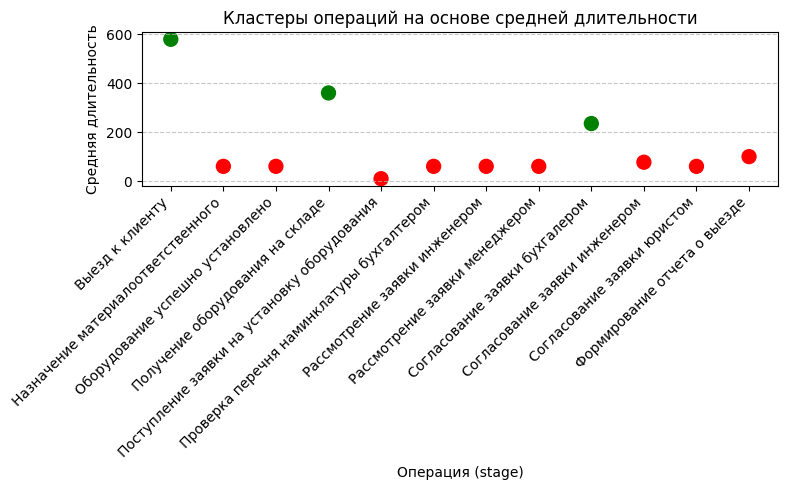

In [26]:
# 1. Рассчитываем среднюю длительность каждой уникальной операции
mean_durations = df.groupby("stage")["duration"].mean().reset_index()
mean_durations.rename(columns={"duration": "mean_duration"}, inplace=True)

# 2. Подготовка данных для OneClassSVM
X = mean_durations[["mean_duration"]].values

# 3. Обучение OneClassSVM
model = OneClassSVM(gamma="auto", nu=0.1)  # nu определяет долю выбросов
model.fit(X)

# 4. Предсказание кластеров
mean_durations["cluster"] = model.predict(X)

# Визуализация
plt.figure(figsize=(8, 5))
colors = mean_durations["cluster"].map({1: "green", -1: "red"})
plt.scatter(mean_durations["stage"], mean_durations["mean_duration"], c=colors, s=100)
plt.title("Кластеры операций на основе средней длительности")
plt.xlabel("Операция (stage)")
plt.ylabel("Средняя длительность")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

> 3 операции выделяются по длительности: выезд к клиенту, получение оборудования на складе и согласование заявки бухгалтером.

#### Функции для расчетов

In [27]:
# Функция для проверки нормальности распределения
def check_normality(data):
    """
    Проверяет нормальность распределения данных:
    1. Коэффициент эксцесса.
    2. Тест Шапиро-Уилка.
    
    Параметры:
    - data: массив данных (список или numpy array).

    Возвращает:
    - Строку с информацие о нормальности распределения
    """
    kurt = kurtosis(data, fisher=True)
    stat, p_value = shapiro(data)
    # Если коэффициент эксцесса != 0 - распеделение не нормальное.
    # Если по тесту Шапиро-Уилка p-value ≤ 0.05 - распределение данных существенно отличается от нормального.
    
    return {"kurt": kurt, "p_value": p_value}

# Функция для расчета дисперсии
def calculate_variance(data):
    """
    Вычисляет дисперсию данных.
    
    Параметры:
    - data: массив данных (список или numpy array).
    
    Возвращает:
    - Дисперсию.
    """
    return np.var(data, ddof=1)  # Используем ddof=1 для выборочной дисперсии

def remove_outliers_with_dbscan(data_series, eps=0.5, min_samples=5):
    """
    Удаляет выбросы из Series с использованием алгоритма DBSCAN.
    
    Параметры:
    - data_series (pd.Series): Входной датасериес с числовыми данными.
    - eps (float): Максимальное расстояние между точками для их классификации как одной кластеры.
    - min_samples (int): Минимальное количество точек для образования кластера.
    
    Возвращает:
    - pd.Series: Исходный датасериес без выбросов.
    """
    if not isinstance(data_series, pd.Series):
        raise ValueError("Входные данные должны быть pandas Series.")
    
    # Преобразуем Series в массив
    data_array = data_series.values.reshape(-1, 1)
    
    # Применяем DBSCAN для кластеризации
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(data_array)
    
    # Удаляем точки, которые классифицированы как шум (label = -1)
    non_outliers = labels != -1
    filtered_series = data_series[non_outliers]
    
    return filtered_series

#### 3.1 Выезд к клиенту / J

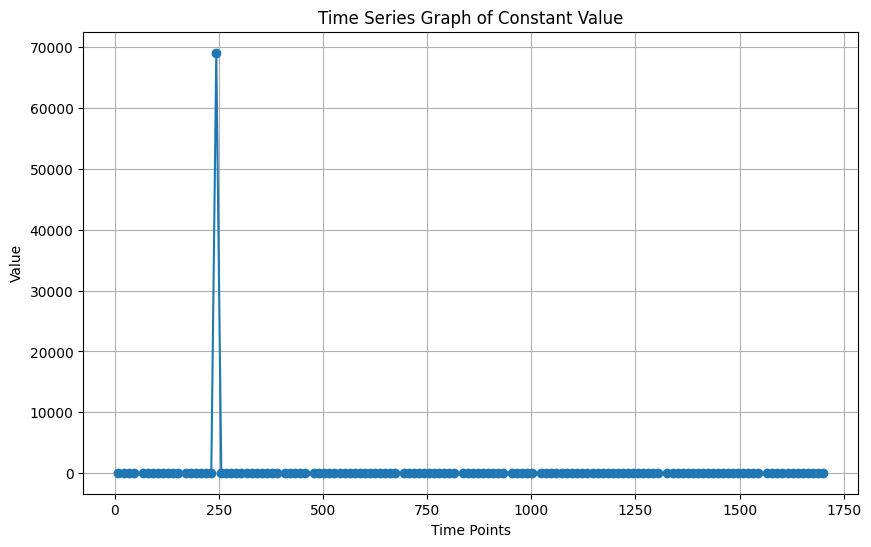

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(df[df['stage_L'] == 'J']['duration'], marker='o', linestyle='-')
plt.title('Time Series Graph of Constant Value')
plt.xlabel('Time Points')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [29]:
# проверяем нормальность
road_normality = check_normality(df[df['stage_L'] == 'J']['duration'])
print(road_normality)
if road_normality['kurt'] != 0 or road_normality['p_value'] <= 0.05:
        print("Распределение не нормальное")
else:
    print("Нормальное распределение")

{'kurt': 128.0075757575759, 'p_value': 2.238925299675645e-25}
Распределение не нормальное


In [30]:
# фильтруем выбросы
road_normality = check_normality(remove_outliers_with_dbscan(df[df['stage_L'] == 'J']['duration']))

print(road_normality)
if road_normality['kurt'] != 0 or road_normality['p_value'] <= 0.05:
        print("Распределение не нормальное")
else:
    print("Нормальное распределение")

{'kurt': nan, 'p_value': 1.0}
Распределение не нормальное


> не знаю к чему отнести - это скорее ошибка в данных. По логике - разовый инцидент

#### 3.2 Получение оборудования на складе / I

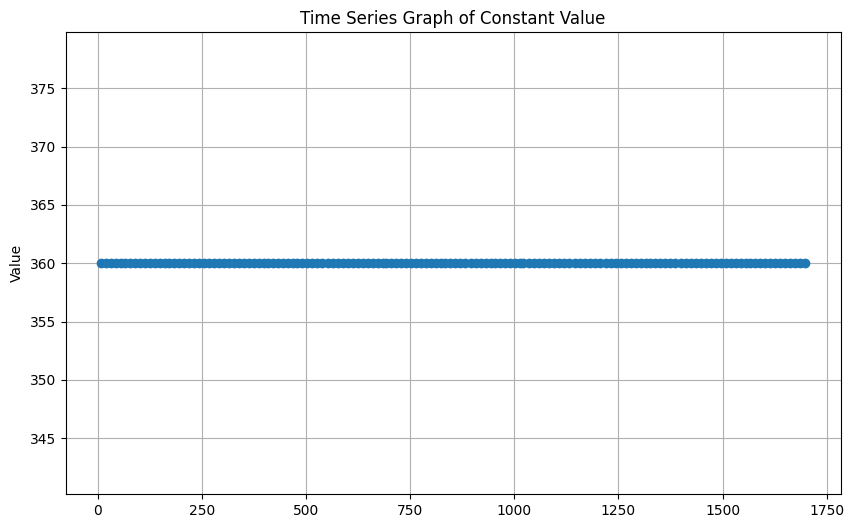

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(df[df['stage_L'] == 'I']['duration'], marker='o', linestyle='-')
plt.title('Time Series Graph of Constant Value')
plt.ylabel('Value')
plt.grid(True)
plt.show()

> просто долгий процесс

#### 3.3 Получение оборудования на складе / F

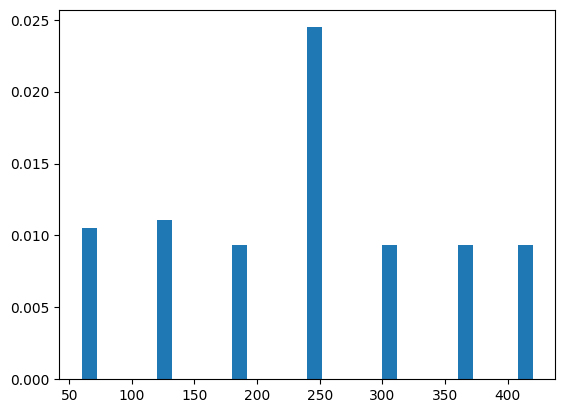

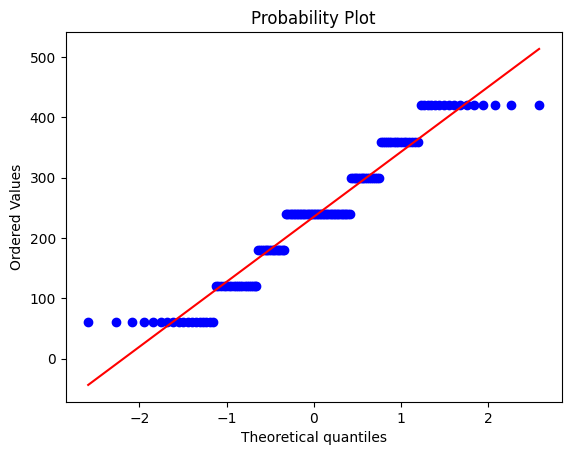

Shapiro-Wilk Test: Statistic=0.9304690957069397, p-value=1.7821037090470782e-06
Kolmogorov-Smirnov Test: Statistic=1.0, p-value=0.0


In [32]:
# Гистограмма
plt.hist(df[df['stage_L'] == 'F']['duration'], bins=30, density=True)
plt.show()

# Q-Q plot
stats.probplot(df[df['stage_L'] == 'F']['duration'], dist="norm", plot=plt)
plt.show()

# Тест Шапиро-Вилка
shapiro_stat, shapiro_p = stats.shapiro(df[df['stage_L'] == 'F']['duration'])
print(f"Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}")

# Тест Колмогорова-Смирнова
ks_stat, ks_p = stats.kstest(df[df['stage_L'] == 'F']['duration'], 'norm')
print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p}")

In [33]:
# проверяем нормальность
acc_normality = check_normality(df[df['stage_L'] == 'F']['duration'])
print(acc_normality)
if acc_normality['kurt'] != 0 and acc_normality['p_value'] <= 0.05:
        print("Распределение не нормальное")
else:
    print("Нормальное распределение")

{'kurt': -0.9007817978753008, 'p_value': 1.7821037090470782e-06}
Распределение не нормальное


In [34]:
acc_filtred = remove_outliers_with_dbscan(df[df['stage_L'] == 'F']['duration'])
acc_normality = check_normality(acc_filtred)

print(acc_normality)
if acc_normality['kurt'] != 0 or acc_normality['p_value'] <= 0.05:
        print("Распределение не нормальное")
else:
    print("Нормальное распределение")

{'kurt': -0.9007817978753008, 'p_value': 1.7821037090470782e-06}
Распределение не нормальное


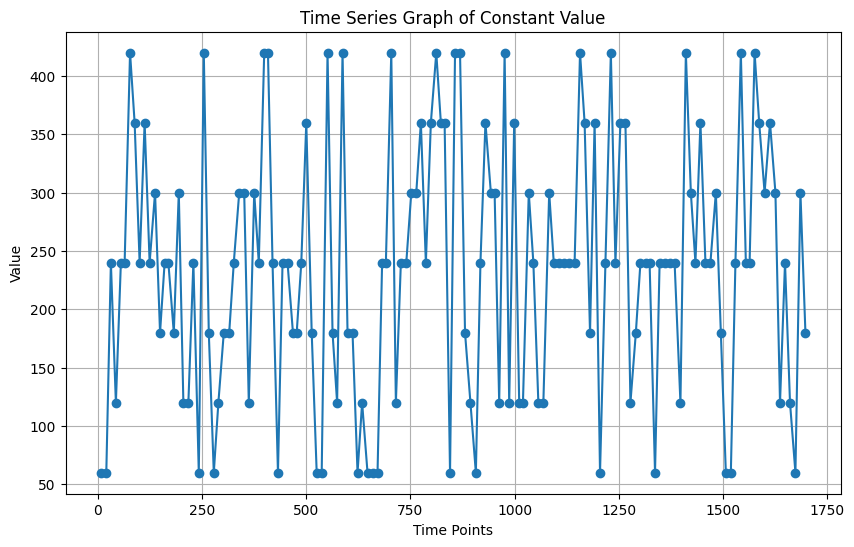

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(remove_outliers_with_dbscan(df[df['stage_L'] == 'F']['duration']) , marker='o', linestyle='-')
plt.title('Time Series Graph of Constant Value')
plt.xlabel('Time Points')
plt.ylabel('Value')
plt.grid(True)
plt.show()

> не знаю точно как классифицировать, возможно многократные инциденты